In [1]:
%load_ext autoreload
%autoreload 2

# Exercise 8

<img src="./images/08.png" width=800>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from tqdm.autonotebook import tqdm
from collections import defaultdict
import os
import numpy as np
import pandas as pd
import mlflow
from torchinfo import summary
import time
from torch.utils.data import Dataset, DataLoader, random_split
from utils import set_seed, weight_reset
from typing import DefaultDict, Any, Callable, Optional


In [ ]:
os.environ['MLFLOW_TRACKING_URI'] = './mlruns08_8'
mlflow.set_tracking_uri(os.environ.get('MLFLOW_TRACKING_URI'))

In [ ]:
mlflow.set_experiment('Exercise08_8')

<Experiment: artifact_location='/home/spakdel/my_projects/Books/Inside-Deep-Learning/Exercises_InsideDeepLearning/Chapter_07/mlruns07_1/143507330168611334', creation_time=1750415411076, experiment_id='143507330168611334', last_update_time=1750415411076, lifecycle_stage='active', name='Exercise07_1', tags={}>

In [3]:
torch.backends.cudnn.deterministic = True
set_seed(42)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Dataset and DataLoader

In [16]:
set_seed(42)

### Loose Boxes

In [20]:
class Class2DetectLoose(Dataset):
    """This class is used to create a simple converstion of a dataset from a classification problem, to a detection problem. """

    def __init__(self, dataset, toSample=3, canvas_size=100):
        """
        dataset: tLoosehe source dataset to sample items from as the "objects" to detect
        toSample: the maximum number of "objects" to put into any image
        canvas_size: the width and height of the images to place objects inside of. 
        """
        self.dataset = dataset
        self.toSample = toSample
        self.canvas_size = canvas_size

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        
        boxes = []
        labels = []
        
        final_size = self.canvas_size
        #First, create a larger image that will store all the "objects" to detect
        img_p = torch.zeros((final_size,final_size), dtype=torch.float32)
        #Now we are going to sample up to self.toSample objects to place into the image
        for _ in range(np.random.randint(1,self.toSample+1)):
            
            #Pick an object at random from the original dataset, and its label
            img, label = self.dataset[np.random.randint(0,len(self.dataset))]
            #Get the height and width of that image
            _, img_h, img_w = img.shape
            #Pick a random offset of the x and y axis, essentially placing the image at a random location
            offsets = np.random.randint(0,final_size-np.max(img.shape),size=(4))
            #Change the padding at the end to make sure we come out to a specific 100,100 shape
            offsets[1] = final_size - img.shape[1] - offsets[0]
            offsets[3] = final_size - img.shape[2] - offsets[2]
            
            with torch.no_grad():
                img_p = img_p + F.pad(img, tuple(offsets))
            #Lets craete the values for the "boxes"
            #all of these are in absolute pixel locations
            
            #x_min determined by the randomly selected offset
            xmin = offsets[0]
            #x_max is the offset plus the image's width
            xmax = offsets[0]+img_w
            #y min/max follows the same pattern
            ymin = offsets[2]
            ymax = offsets[2]+img_h
            #now we add to the box with the right label
            boxes.append( [xmin, ymin, xmax, ymax] )
            labels.append( label )

            
        target = {}
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        
        return img_p, target
#Caption: This class defines a toy MNIST detector. Images from the MNIST dataset are placed at random locations in an image. The object detector will try to learn to predict where digits are, and what digit is at each location. 

In [21]:
def collate_fn(batch):
    """
    batch is going to contain a python list of objects. In our case, our data loader returns (Tensor, Dict) pairs
    The FasterRCNN algorithm wants a List[Tensors] and a List[Dict]. So we will use this function to convert the 
    batch of data into the form we want, and then give it to the Dataloader to use
    """
    imgs = []
    labels = []
    for img, label in batch:
        imgs.append(img)
        labels.append(label)
    return imgs, labels

In [22]:
train_data_loose = Class2DetectLoose(torchvision.datasets.MNIST("./data", train=True, transform=transforms.ToTensor(), download=True))
test_data_loose = Class2DetectLoose(torchvision.datasets.MNIST("./data", train=False, transform=transforms.ToTensor(), download=True))
batch_size = 128
train_loader_loose = DataLoader(train_data_loose, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader_loose = DataLoader(test_data_loose, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

Sample Image Shape: torch.Size([1, 100, 100])
Sample Target Boxes:
 tensor([[14., 60., 42., 88.],
        [23., 21., 51., 49.],
        [29.,  1., 57., 29.]])
Sample Target Labels:
 tensor([0, 1, 8])


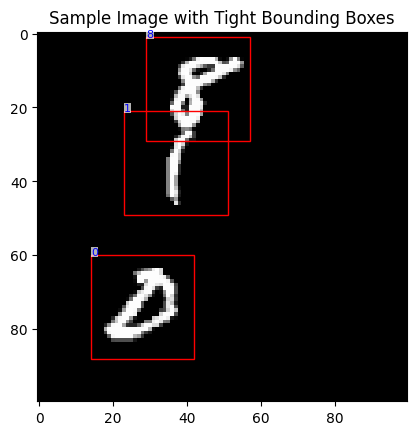

Batch 1:
  Number of images: 128
  First image shape: torch.Size([1, 100, 100])
  First target boxes shape: torch.Size([1, 4])
  First target labels shape: torch.Size([1])


In [ ]:
# Example usage to verify
if __name__ == '__main__':
    sample_img, sample_target = train_data_loose[890]
    print("Sample Image Shape:", sample_img.shape)
    print("Sample Target Boxes:\n", sample_target['boxes'])
    print("Sample Target Labels:\n", sample_target['labels'])

    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    # Visualize a sample image with its tight bounding boxes
    fig, ax = plt.subplots(1)
    # Unsqueeze to remove batch dim if only one image, squeeze to remove channel dim
    ax.imshow(sample_img.squeeze(0).numpy(), cmap='gray')
    for i in range(sample_target['boxes'].shape[0]):
        box = sample_target['boxes'][i].numpy()
        label = sample_target['labels'][i].item()
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, str(label), color='blue', fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0))
    plt.title("Sample Image with Tight Bounding Boxes")
    plt.show()

### Tight Boxes

In [24]:
class Class2DetectTight(Dataset):
    """This class is used to create a simple converstion of a dataset from a classification problem, to a detection problem. """

    def __init__(self, dataset, toSample=3, canvas_size=100):
        """
        dataset: the source dataset to sample items from as the "objects" to detect
        toSample: the maximum number of "objects" to put into any image
        canvas_size: the width and height of the images to place objects inside of.
        """
        self.dataset = dataset
        self.toSample = toSample
        self.canvas_size = canvas_size

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        boxes = []
        labels = []

        final_size = self.canvas_size
        #First, create a larger image that will store all the "objects" to detect
        img_p = torch.zeros((1, final_size, final_size), dtype=torch.float32) # Changed to 1 channel for consistency
        #Now we are going to sample up to self.toSample objects to place into the image
        for _ in range(np.random.randint(1,self.toSample+1)):

            #Pick an object at random from the original dataset, and its label
            img, label = self.dataset[np.random.randint(0,len(self.dataset))]
            #Get the height and width of that image
            # _, img_h, img_w = img.shape # We will get these from the tight bbox now

            # --- MODIFICATION START ---
            # Find the tight bounding box for the digit in the original MNIST image
            # Assuming img is 1 channel (C, H, W) where C=1
            non_zero_coords = torch.nonzero(img.squeeze(0)) # Get (row, col) of non-zero pixels
            if non_zero_coords.numel() == 0: # Handle cases where the digit might be completely black (shouldn't happen with MNIST)
                continue # Skip this digit if it's empty

            y_min_digit = torch.min(non_zero_coords[:, 0]).item()
            y_max_digit = torch.max(non_zero_coords[:, 0]).item()
            x_min_digit = torch.min(non_zero_coords[:, 1]).item()
            x_max_digit = torch.max(non_zero_coords[:, 1]).item()

            # Calculate the dimensions of the tight digit image
            tight_img_h = y_max_digit - y_min_digit + 1
            tight_img_w = x_max_digit - x_min_digit + 1

            # Crop the digit image to its tight bounding box
            tight_img = img[:, y_min_digit:y_max_digit+1, x_min_digit:x_max_digit+1]
            # --- MODIFICATION END ---


            #Pick a random offset of the x and y axis for placing the tight_img
            # The available space for placement is canvas_size - tight_img_dim
            offset_y = np.random.randint(0, final_size - tight_img_h + 1)
            offset_x = np.random.randint(0, final_size - tight_img_w + 1)

            # Calculate padding for the tightly cropped image
            # pad_left, pad_right, pad_top, pad_bottom
            pad_left = offset_x
            pad_right = final_size - offset_x - tight_img_w
            pad_top = offset_y
            pad_bottom = final_size - offset_y - tight_img_h

            with torch.no_grad():
                # Apply padding to the tight_img and add it to the canvas
                img_p += F.pad(tight_img, (pad_left, pad_right, pad_top, pad_bottom))

            # Let's create the values for the "boxes"
            # These are in absolute pixel locations on the final_size canvas
            xmin = offset_x
            xmax = offset_x + tight_img_w
            ymin = offset_y
            ymax = offset_y + tight_img_h

            #now we add to the box with the right label
            boxes.append( [xmin, ymin, xmax, ymax] )
            labels.append( label )


        target = {}
        target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)

        # Ensure the final image is 1-channel (if it wasn't already)
        return img_p, target

In [25]:
def collate_fn(batch):
    imgs = []
    labels = []
    for img, label in batch:
        imgs.append(img)
        labels.append(label)
    return imgs, labels

In [ ]:
train_data_tight = Class2DetectTight(torchvision.datasets.MNIST("./data", train=True, transform=transforms.ToTensor(), download=True))
test_data_tight = Class2DetectTight(torchvision.datasets.MNIST("./data", train=False, transform=transforms.ToTensor(), download=True))
train_loader_tight = DataLoader(train_data_tight, batch_size=128, shuffle=True, collate_fn=collate_fn)
test_loader_tight = DataLoader(test_data_tight, batch_size=128, shuffle=True, collate_fn=collate_fn)


Sample Image Shape: torch.Size([1, 100, 100])
Sample Target Boxes:
 tensor([[ 6., 55., 14., 75.],
        [17., 22., 31., 42.]])
Sample Target Labels:
 tensor([1, 4])


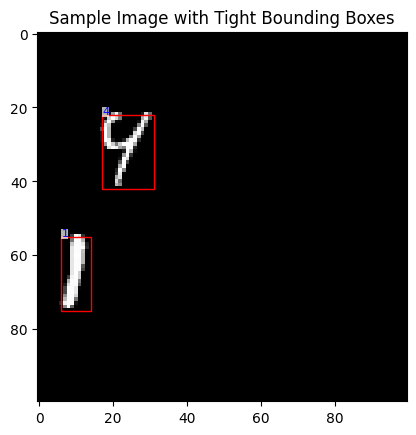

Batch 1:
  Number of images: 128
  First image shape: torch.Size([1, 100, 100])
  First target boxes shape: torch.Size([2, 4])
  First target labels shape: torch.Size([2])


In [ ]:
# Example usage to verify
if __name__ == '__main__':
    sample_img, sample_target = train_data_tight[890]
    print("Sample Image Shape:", sample_img.shape)
    print("Sample Target Boxes:\n", sample_target['boxes'])
    print("Sample Target Labels:\n", sample_target['labels'])

    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    # Visualize a sample image with its tight bounding boxes
    fig, ax = plt.subplots(1)
    # Unsqueeze to remove batch dim if only one image, squeeze to remove channel dim
    ax.imshow(sample_img.squeeze(0).numpy(), cmap='gray')
    for i in range(sample_target['boxes'].shape[0]):
        box = sample_target['boxes'][i].numpy()
        label = sample_target['labels'][i].item()
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, str(label), color='blue', fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0))
    plt.title("Sample Image with Tight Bounding Boxes")
    plt.show()

## Model

In [ ]:
C = 1
classes = 10
n_filters = 32

In [ ]:
def cnn_layer(in_filters, out_filters, kernel_size=3):
    """
    in_filters: how many channels are in the input to this layer
    out_filters: how many channels should this layer output
    kernel_size: how large should the filters of this layer be
    """
    padding = kernel_size//2
    return nn.Sequential(
        nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding), 
        nn.BatchNorm2d(out_filters),
        nn.LeakyReLU(), # I'm not setting the leak value to anything just to make the code shorter. 
    )
backbone = nn.Sequential(
    cnn_layer(C, n_filters),    
    cnn_layer(n_filters, n_filters),
    cnn_layer(n_filters, n_filters),
    nn.MaxPool2d((2,2)),
    cnn_layer(n_filters, 2*n_filters),
    cnn_layer(2*n_filters, 2*n_filters),
    cnn_layer(2*n_filters, 2*n_filters),
    nn.MaxPool2d((2,2)),
    cnn_layer(2*n_filters, 4*n_filters),
    cnn_layer(4*n_filters, 4*n_filters),
)
#Let Faster RCNN know exactly how many output channels to expect
backbone.out_channels = n_filters*4

In [ ]:
# How many proposals $k$ should be generated? Every aspect ration will be one, and the process will be repeated for multiple image sizes 
anchor_generator = AnchorGenerator(sizes=((32),), aspect_ratios=((1.0),)) #To make this run faster, we are telling PyTorch to look for only square images that are 32 x 32 in size

#Tell PyTorch to use the final output of the backbone as the featuremap (['0']), use adaptive pooling down to a 7x7 grid (output_size=7)
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
#sampling_ratio is poorly named, and controls details on how the RoI grabs slices of the feature map when a fractional pixel location is predicted (e.g., 5.8 instead of 6). We are not going to go into those low level details, 2 is a reasonable default for most work. 
        
#Now we can create the FasterRCNN object. We give it the backbone network, number of classes, min & max size to process images at (we know all our images at 100 pixels), a mean and standard deviation to subtract from the images, and the anchor generation (RPN) and RoI objects
model = FasterRCNN(backbone, num_classes=10, image_mean = [0.5], image_std = [0.229], min_size=100, max_size=100, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)

## Training

In [ ]:
from torchmetrics.detection import MeanAveragePrecision

In [ ]:
epochs = 2
params = {
    'device': device,
    'epochs': epochs,
    'batch_size': batch_size,
    }

In [ ]:
def train_network(optimizer, metric_calculator ,train_loader, test_loader=None):
    results = defaultdict(list)
    total_train_time = 0

    # --- Main Training and Validation Loop ---
    for epoch in tqdm(range(epochs), desc="Epoch"):
        results['epoch'].append(epoch)
        
        # ===================================
        #           TRAINING
        # ===================================
        model.train() # Set model to training mode
        running_train_loss = []
        start_time = time.time()
        
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            inputs = [img.to(device) for img in inputs]
            labels = [{k: v.to(device) for k, v in t.items()} for t in labels]

            # Get losses
            loss_dict = model(inputs, labels)
            loss = sum(l for l in loss_dict.values())
            
            # Backpropagate
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_train_loss.append(loss.item())

        # --- Log Training Results for Epoch ---
        total_train_time += (time.time() - start_time)
        avg_train_loss = np.mean(running_train_loss)
        results['train loss'].append(avg_train_loss)
        results['total time'].append(total_train_time)
        
        mlflow.log_metric("train_loss", avg_train_loss, step=epoch)
        mlflow.log_metric('Time', total_train_time, step=epoch)

        # ===================================
        #           VALIDATION
        # ===================================
        if test_loader is not None:
            metric_calculator.reset() # Reset metrics before each validation run
            running_valid_loss = []
            
            with torch.no_grad(): # Disable gradient calculations
                for inputs, labels in tqdm(test_loader, desc="Validating", leave=False):
                    inputs = [img.to(device) for img in inputs]
                    labels = [{k: v.to(device) for k, v in t.items()} for t in labels]
                    
                    # 1. Get validation loss (model in .train() mode)
                    model.train()
                    loss_dict = model(inputs, labels)
                    loss = sum(l for l in loss_dict.values())
                    running_valid_loss.append(loss.item())

                    # 2. Get predictions for metrics (model in .eval() mode)
                    model.eval()
                    predictions = model(inputs)
                    
                    # Update the metric calculator with the new predictions and labels
                    metric_calculator.update(predictions, labels)

            # --- Log Validation Results for Epoch ---
            avg_valid_loss = np.mean(running_valid_loss)
            results['valid loss'].append(avg_valid_loss)
            mlflow.log_metric("valid_loss", avg_valid_loss, step=epoch)

            # Compute and log the final mAP scores
            metrics = metric_calculator.compute()
            results['valid_mAP'].append(metrics['map'].item())
            mlflow.log_metric("valid_mAP", metrics['map'].item(), step=epoch)
            mlflow.log_metric("valid_mAP_50", metrics['map_50'].item(), step=epoch)
            mlflow.log_metric("valid_mAP_75", metrics['map_75'].item(), step=epoch)

        # print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Valid Loss: {avg_valid_loss:.4f} | mAP: {metrics['map'].item():.4f}")

In [ ]:
experiments = ('losse boxes', 'tight boxes')
train_datasets = (train_data_loose, train_data_tight)
train_loaders = (train_loader_loose, train_loader_tight)
test_loaders = (test_loader_loose, test_loader_tight)

In [ ]:
for i, experiment in enumerate(experiments):
    print(experiment)
    train_loader = train_loaders[i]
    test_loader = test_loaders[i]
    train_dataset = train_datasets[i]
    model.apply(weight_reset)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    params['optimizer'] = optimizer.defaults

    # --- Metric Calculator ---
    # This object will accumulate predictions and targets to calculate mAP
    metric_calculator = MeanAveragePrecision(box_format="xyxy")

    with mlflow.start_run(run_name=experiment):
        mlflow.log_artifact('model_summary.txt')
        mlflow.log_params(params)
        with open('model_summary.txt', 'w') as f:
            f.write(str(summary(model, inpt_size=(batch_size,tuple(train_dataset[0][0].shape)))))
        train_network(
            optimizer=optimizer,
            metric_calculator=metric_calculator,
            train_loader=train_loader,
            test_loader=test_loader,
            )


## Results

### Why Tight Boxes are Better

#### Reduced Background Noise:

- Loose Boxes: When the ground-truth box is loose, it contains a large amount of empty background pixels. The model is forced to learn that these irrelevant black pixels are part of the "digit" object. This creates a noisy, weak signal for both classification and box regression.

- Tight Boxes: The ground-truth box contains almost exclusively pixels belonging to the digit. This provides a clean, strong signal, allowing the model to learn the digit's actual features much more effectively.

#### Accurate Intersection over Union (IoU) Calculation:

- Loose Boxes: A major problem arises during evaluation. Your model might predict a perfectly tight box around a digit. However, when this excellent prediction is compared to the large, loose ground-truth box, the IoU score will be low. The model gets penalized for being more accurate than the label. This makes the training objective for the box regressor confusing and results in a lower mAP score that doesn't reflect the model's true ability.

- Tight Boxes: When the ground truth is also tight, a good prediction results in a high IoU. The training signal is correct, and the evaluation metric (mAP) accurately reflects the model's localization performance.

#### Expected Results on Test Images
When you visualize the predictions on test images:

- Model Trained on Loose Boxes: The predicted bounding boxes will likely be sloppy and oversized. They will mimic the loose boxes seen during training. Confidence scores may be lower because the model is less certain about the noisy features.

- Model Trained on Tight Boxes: The predicted bounding boxes will be visibly more precise and will snugly fit the digits. The localization will be far superior, and confidence scores will likely be higher. The overall result will look much more professional and accurate.